# Reverse optimization of school preferability parameters under MNL choice model

Max Kapur | <a href="https://www.maxkapur.com/">maxkapur.com</a>

As part of my research into admissions markets, I model student preferences using the multinomial logit choice function, which assigns each school a preferability parameter $\delta_c$. Then, given a set of admitted schools $C^\#$, students attend school $c$ with probability $$\frac{\exp \delta_c}{\sum_{d \in C^\#} \exp \delta_d}$$

When all schools use a common ranking over the students and admit students whose score exceeds a certain percentile $p_c$, then the demand for (percentage of students choosing to attend) school $c$ is given by the following expression:

$$D_c(p) = 
\sum_{d=c}^{|C|} 
\underbrace{\frac{\exp{\delta_c}}{ \sum_{i=1}^d \exp{\delta_i}}}_{\substack{\text{prob. of choosing  }\\ c\text{ from assortment}}} 
\overbrace{\left(p_{d+1} - p_{d}\right)}^{\substack{\text{prob. of having}\\ \text{assortment }C_{[d]}}} $$

Here we assume the schools are ordered by cutoff ($p_1 \leq \cdots \leq p_{|C|}$), and we take $p_{|C|+1} \equiv 1$. $C_{[d]}$ refers to the admitted school set consisting of the first $d$ schools.

The question asked here is, **given the demand for each school and its admissions cutoff, can we figure out the market's underlying preferability parameters?** This is not an easy question, because while schools publish their admissions rates and yield, these cannot be taken as a measure of overall preferability, because not all students apply to every school.

To start off with, we need some data to play with; since the assumption that all schools use a common ranking is itself unrealistic, I haven&rsquo;t  fretted too much about the details of how to derive the school cutoffs&mdash;Part 1 is just a proof of concept.

## Part 1: Data preprocessing in Python

Data source: https://www.kaggle.com/samsonqian/college-admissions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's make the unrealistic assumption that each school admits every student using their standardized test scores. I will try to do this in a sort of clever way. The data we have gives the 25th and 75th percentile score of its admitted students' standardized test scores, and the distributions of these scores are known.

For example, U of Alabama's 75th percentile ACT composite score is a 40, which is at the 90th percentile overall; if the U of Alabama looks only at ACT composite scores, it follows that the 0th percentile of Alabama's admits is at the 60th percentile among all testtakers. Combining all the test, the data implies 8 different values for the minimum cutoff at each score, and I take a weighted average of these based on the number of applicants who submitted each test to derive a cutoff.

In [87]:
stats = pd.read_csv("admitstats_raw.csv")[['Name',
                                           'Enrolled total',
                                           'Percent of freshmen submitting SAT scores',
                                           'Percent of freshmen submitting ACT scores',
                                           'SAT Critical Reading 25th percentile score',
                                           'SAT Critical Reading 75th percentile score',
                                           'SAT Math 25th percentile score',
                                           'SAT Math 75th percentile score',
                                           'SAT Writing 25th percentile score',
                                           'SAT Writing 75th percentile score',
                                           'ACT Composite 25th percentile score',
                                           'ACT Composite 75th percentile score']]
stats.dropna(inplace=True)

In [88]:
stats

,Name,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score
5,The University of Alabama,6454.0,23.0,76.0,490.0,620.0,500.0,640.0,480.0,600.0,22.0,30.0
8,Auburn University,3726.0,17.0,83.0,520.0,620.0,540.0,650.0,510.0,620.0,24.0,30.0
14,Judson College,68.0,10.0,94.0,550.0,640.0,500.0,600.0,530.0,610.0,19.0,24.0
18,University of Montevallo,531.0,3.0,96.0,495.0,613.0,465.0,550.0,440.0,580.0,20.0,26.0
21,Samford University,765.0,36.0,84.0,500.0,630.0,510.0,610.0,500.0,610.0,23.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1503,Florida Gulf Coast University,2761.0,83.0,67.0,470.0,550.0,470.0,550.0,460.0,540.0,20.0,24.0
1516,Ave Maria University,254.0,69.0,64.0,460.0,620.0,470.0,590.0,460.0,600.0,20.0,26.0
1525,University of South Florida-St Petersburg,562.0,51.0,48.0,490.0,590.0,490.0,570.0,470.0,560.0,21.0,25.0
1529,University of South Florida-Sarasota-Manatee,86.0,79.0,59.0,502.0,580.0,490.0,570.0,490.0,570.0,22.0,25.0


In [89]:
stats['name'] = stats['Name']; del stats['Name']
stats['demand'] = stats['Enrolled total'].astype(int)
stats

,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,name,demand
5,6454.0,23.0,76.0,490.0,620.0,500.0,640.0,480.0,600.0,22.0,30.0,The University of Alabama,6454
8,3726.0,17.0,83.0,520.0,620.0,540.0,650.0,510.0,620.0,24.0,30.0,Auburn University,3726
14,68.0,10.0,94.0,550.0,640.0,500.0,600.0,530.0,610.0,19.0,24.0,Judson College,68
18,531.0,3.0,96.0,495.0,613.0,465.0,550.0,440.0,580.0,20.0,26.0,University of Montevallo,531
21,765.0,36.0,84.0,500.0,630.0,510.0,610.0,500.0,610.0,23.0,28.0,Samford University,765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,2761.0,83.0,67.0,470.0,550.0,470.0,550.0,460.0,540.0,20.0,24.0,Florida Gulf Coast University,2761
1516,254.0,69.0,64.0,460.0,620.0,470.0,590.0,460.0,600.0,20.0,26.0,Ave Maria University,254
1525,562.0,51.0,48.0,490.0,590.0,490.0,570.0,470.0,560.0,21.0,25.0,University of South Florida-St Petersburg,562
1529,86.0,79.0,59.0,502.0,580.0,490.0,570.0,490.0,570.0,22.0,25.0,University of South Florida-Sarasota-Manatee,86


Using the table found [here](https://web.archive.org/web/20161128224433/https://collegereadiness.collegeboard.org/pdf/understanding-sat-scores-2016.pdf), convert the cutoff scores to percentiles with respect to the totality of SAT takers. 

In [94]:
ACTpc = pd.read_csv("ACT-percentiles.csv")
ACTpc.index = ACTpc['score']
ACTpc

SATcomppc = pd.read_csv("SAT-composite-percentiles.csv")
SATcomppc.index = SATcomppc['score']
SATsubspc = pd.read_csv("SAT-subscore-percentiles.csv")
SATsubspc.index = SATsubspc['score']
SATsubspc

,score,readpercentile,mathpercentile,writpercentile
score,,,,
200,200,0.00,0.00,0.00
210,210,0.01,0.00,0.01
220,220,0.01,0.00,0.01
230,230,0.01,0.01,0.01
240,240,0.01,0.01,0.01
...,...,...,...,...
760,760,0.99,0.97,0.99
770,770,0.99,0.98,0.99
780,780,0.99,0.99,0.99


In [95]:
newcol = []

for i in stats['SAT Critical Reading 25th percentile score']:
    lb = int(np.floor(i/10))
    d = i/10 - lb
    res = (1-d) * SATsubspc['readpercentile'].loc[10*lb]
    if d > 0:
        res += d*SATsubspc['readpercentile'].loc[10*lb+10]
    newcol.append(max(0, 1 - (1-res)/.75))
    
stats['SAT25-read-implied-cutoff'] = newcol

In [104]:
newcol = []

for i in stats['SAT Critical Reading 75th percentile score']:
    lb = int(np.floor(i/10))
    d = i/10 - lb
    res = (1-d) * SATsubspc['readpercentile'].loc[10*lb]
    if d > 0:
        res += d*SATsubspc['readpercentile'].loc[10*lb+10]
    newcol.append(max(0, 1 - (1-res)/.25))
    
stats['SAT75-read-implied-cutoff'] = newcol

newcol = []

for i in stats['SAT Math 25th percentile score']:
    lb = int(np.floor(i/10))
    d = i/10 - lb
    res = (1-d) * SATsubspc['mathpercentile'].loc[10*lb]
    if d > 0:
        res += d*SATsubspc['mathpercentile'].loc[10*lb+10]
    newcol.append(max(0, 1 - (1-res)/.75))
    
stats['SAT25-math-implied-cutoff'] = newcol

newcol = []

for i in stats['SAT Math 75th percentile score']:
    lb = int(np.floor(i/10))
    d = i/10 - lb
    res = (1-d) * SATsubspc['mathpercentile'].loc[10*lb]
    if d > 0:
        res += d*SATsubspc['mathpercentile'].loc[10*lb+10]
    newcol.append(max(0, 1 - (1-res)/.25))
    
stats['SAT75-math-implied-cutoff'] = newcol

newcol = []

for i in stats['SAT Writing 25th percentile score']:
    lb = int(np.floor(i/10))
    d = i/10 - lb
    res = (1-d) * SATsubspc['writpercentile'].loc[10*lb]
    if d > 0:
        res += d*SATsubspc['writpercentile'].loc[10*lb+10]
    newcol.append(max(0, 1 - (1-res)/.75))
    
stats['SAT25-writ-implied-cutoff'] = newcol

newcol = []

for i in stats['SAT Writing 75th percentile score']:
    lb = int(np.floor(i/10))
    d = i/10 - lb
    res = (1-d) * SATsubspc['writpercentile'].loc[10*lb]
    if d > 0:
        res += d*SATsubspc['writpercentile'].loc[10*lb+10]
    newcol.append(max(0, 1 - (1-res)/.25))
    
stats['SAT75-writ-implied-cutoff'] = newcol

newcol = []

for i in stats['ACT Composite 25th percentile score']:
    lb = int(np.floor(i))
    d = i - lb
    res = (1-d) * ACTpc['percentile'].loc[lb]
    if d > 0:
        res += d*ACTpc['percentile'].loc[lb+1]
        
    # Now res represents the percentile score associated with
    # the reported 25th percentile score. Implied minimum is
        
    newcol.append(max(0, 1 - (1-res)/.75))
    
stats['ACT25-implied-cutoff'] = newcol

newcol = []

for i in stats['ACT Composite 75th percentile score']:
    lb = int(np.floor(i))
    d = i - lb
    res = (1-d) * ACTpc['percentile'].loc[lb]
    if d > 0:
        res += d*ACTpc['percentile'].loc[lb+1]
    newcol.append(max(0, 1 - (1-res)/.25))
    
stats['ACT75-implied-cutoff'] = newcol

In [142]:
def weighted_avger(entry):
    vals = entry[['SAT25-read-implied-cutoff', 'SAT75-read-implied-cutoff',
                 'SAT25-math-implied-cutoff', 'SAT75-math-implied-cutoff',
                 'SAT25-writ-implied-cutoff', 'SAT75-writ-implied-cutoff',
                 'ACT25-implied-cutoff', 'ACT75-implied-cutoff']]
    weights = entry[['Percent of freshmen submitting SAT scores'] * 6 + ['Percent of freshmen submitting ACT scores'] * 2]
    
    return np.average(vals, weights=weights)

In [143]:
stats['cutoff'] = stats.apply(axis=1, func=weighted_avger)

In [145]:
stats = stats[['name','demand','cutoff']]

In [146]:
stats

,name,demand,cutoff
5,The University of Alabama,6454,0.430138
8,Auburn University,3726,0.538160
14,Judson College,68,0.167629
18,University of Montevallo,531,0.201592
21,Samford University,765,0.387708
...,...,...,...
1503,Florida Gulf Coast University,2761,0.108490
1516,Ave Maria University,254,0.199363
1525,University of South Florida-St Petersburg,562,0.164911
1529,University of South Florida-Sarasota-Manatee,86,0.180183


In [149]:
# Sanity check
stats_sorted = stats.sort_values('cutoff')
stats_sorted

,name,demand,cutoff
1105,Lincoln University of Pennsylvania,448,0.000000
933,North Carolina Central University,1407,0.000000
1117,Neumann University,503,0.000000
555,Mount Ida College,307,0.000000
1305,Sul Ross State University,310,0.000000
...,...,...,...
551,Massachusetts Institute of Technology,1115,0.949992
289,University of Chicago,1426,0.950115
544,Harvard University,1659,0.954330
179,Yale University,1356,0.954392


Get a sense for the shape of the cutoff distribution. 

<BarContainer object of 677 artists>

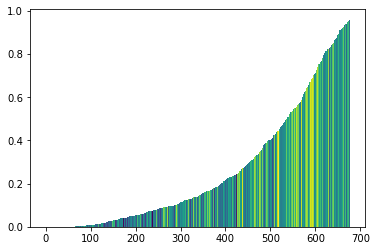

In [150]:
colspace = np.log(stats_sorted['demand'].to_numpy())
colspace -= colspace.min()
colspace /= colspace.max()

colors = plt.get_cmap('viridis')(colspace)

# Cutoffs in order, colored by demand
plt.bar(x=range(len(stats_sorted)), height=stats_sorted['cutoff'], width=1,
        color=colors)

In [151]:
stats.to_csv('admitstats.csv', index=False)